In [1]:
# Base libraries
from collections import namedtuple, deque
from dataclasses import dataclass
from typing import List, Tuple, Dict, Callable, Any
import numpy as np
import pandas as pd
import random

# ML libraries
import torch

# Local imports
from board import ConnectFourField
from env import Env
from agents.random_agent import RandomAgent
from agents.deep_q_agent import DeepQAgent
from agents.cql_agent import CQLAgent
from agents.minimax_agent import MinimaxAgent
import utils

# Fix random seed
utils.seed_everything()

# Import Transformers
from transformers import DecisionTransformerConfig, DecisionTransformerModel, Trainer, TrainingArguments

In [2]:
# Transition = namedtuple('Trajectory', ('length', 'states', 'actions', 'rewards', 'RTGs'))

# """Implement memory class"""
# class Memory(object):
#     def __init__(self, max_capacity):
#         self.memory = deque([], maxlen=max_capacity)

#     def push(self, *args):
#         self.memory.append(Transition(*args))

#     def sample(self, batch_size: int, split_transitions: bool = False):
#         minibatch = random.sample(self.memory, batch_size)

#         if split_transitions:
#             states, actions, rewards, RTGs, time_steps = [], [], [], [], []
        
#             for state, action, reward, RTG, time_step in minibatch:
#                 states.append(state)
#                 actions.append(action)
#                 rewards.append(reward)
#                 RTGs.append(RTG)
#                 time_steps.append(time_step)
            
#             minibatch = [states, actions, rewards, RTGs, time_steps]

#             for i in range(len(minibatch)):
#                 minibatch[i] = torch.tensor(minibatch[i], dtype=torch.float32)
        
#         return minibatch
    
#     def __len__(self):
#         return len(self.memory)
    
#     def reset(self):
#         self.memory.clear()


In [3]:
#TODO: Move this code into utils, or the corresponding agent or somewhere..

def calculate_RTG(rewards):
    RTGs = []
    for i in range(0,len(rewards)):
        #Sum up all the rewards occuring in the current timestep until the end!
        RTGs.append(sum(rewards[i:]))
    return RTGs
    


In [14]:
# Generate T_offline (offline Trajectories for the offline initialization of the replay buffer)
# NOTE: alternative would be to initialize with either Random Trajs, or with Traj.s from DQN Agent / CQL Agent
# NOTE: Corresponding paper: https://arxiv.org/pdf/2202.05607.pdf

AGENT = 1
OPPONENT = 2
NUM_TRAJ = 300
offline_trajectories = []

#Initialize Environment and Agent
env = Env()
agent = MinimaxAgent(env, epsilon=0.3, whoami=AGENT)
opponent = MinimaxAgent(env, epsilon=0.3, whoami=OPPONENT)

agent_won = 0
agent_lost = 0

for i in range(0, NUM_TRAJ):

    # Initialize other variables
    finished = -1

    #Initialize fields for trajectory
    states = []
    actions = []
    rewards = []
    dones = []

    # Make it random who gets to start the game
    # Set to true during the episode
    agent_start = random.choice([True, False])
    # Run one episode of the game
    while finished == -1:
        # Agent makes a turn
        if agent_start:
            state = env.get_state()
            #action = agent.act(state)
            action = agent.act(env.field)
            valid, reward, finished = agent.env.step(action, AGENT)
            
            # Update current Trajectory
            #Flatten the state to be a 42-entry 1 dimensional array
            states.append(np.ravel(state))
            actions.append(action)
            rewards.append(reward)

            if finished != -1:
                break

        else:
            agent_start = True

        # Opponent makes their turn
        #action = opponent.act(env.get_state_inverted())
        action = opponent.act(env.field)
        valid, _, finished = opponent.env.step(action, OPPONENT)

        if finished != -1: 
            break

    # The Flag if the Episode is finished is False for n-1 steps and True for the last step obviously..
    dones = ([False] * (len(rewards)-1)) + [True]
   
    assert len(states) == len(actions)
    assert len(actions) == len(rewards)
    assert len(dones) == len(rewards)
    length = len(states)
    RTGs = calculate_RTG(rewards)
    traj = [length, states, actions, rewards, RTGs, dones]
    offline_trajectories.append(traj)

    #Keep track of statistics
    if finished == 1:
        agent_won+=1
    elif finished == 2:
        agent_lost+=1

    if i % int(NUM_TRAJ/10) == 0:
        print(f"Episode: {i}, RTG (start) : {RTGs[0]}, length: {length}, reward end: {rewards[-1]}, done: {dones[-1]}")
        print(f"Score: Agent {agent_won} - {agent_lost} Opponent")
        #env.render_pretty()
    env.reset()
    
# Final score
print(f"Score: Agent {agent_won} - {agent_lost} Opponent")

# Sort offline buffer such that the order is descending in RTGs
# [4][0] is the first RTG of the trajectory
sorted_offline_trajectories = sorted(offline_trajectories, key=lambda x: x[4][0], reverse = True)


#TODO: Currently the opponent minimax agent wins about 66% of the games, this shouldn't be the case right? Maybe still some implementation issue with the Agent being on either side..


Episode: 0, RTG (start) : 1, length: 20, reward end: 1, done: True
Score: Agent 1 - 0 Opponent
Episode: 30, RTG (start) : 1, length: 16, reward end: 1, done: True
Score: Agent 13 - 16 Opponent
Episode: 60, RTG (start) : 0, length: 15, reward end: 0, done: True
Score: Agent 32 - 26 Opponent
Episode: 90, RTG (start) : 0, length: 21, reward end: 0, done: True
Score: Agent 46 - 38 Opponent
Episode: 120, RTG (start) : 0, length: 14, reward end: 0, done: True
Score: Agent 59 - 54 Opponent
Episode: 150, RTG (start) : 0, length: 21, reward end: 0, done: True
Score: Agent 72 - 69 Opponent
Episode: 180, RTG (start) : 1, length: 9, reward end: 1, done: True
Score: Agent 87 - 82 Opponent
Episode: 210, RTG (start) : 1, length: 17, reward end: 1, done: True
Score: Agent 103 - 95 Opponent
Episode: 240, RTG (start) : 0, length: 16, reward end: 0, done: True
Score: Agent 117 - 111 Opponent
Episode: 270, RTG (start) : 0, length: 12, reward end: 0, done: True
Score: Agent 132 - 126 Opponent
Score: Agent 

In [5]:
print(agent_won)

85


In [6]:
# We have a dataset containing all the offline collected data
# Using this tutorial: https://huggingface.co/blog/train-decision-transformers
# We convert the dataset into data ready for the decision transformer
FRACTION = 1
N = int(FRACTION * NUM_TRAJ)
dataset = sorted_offline_trajectories[:N]
lengths = [x[0] for x in dataset]
max_episode_length = max(lengths)
print(f"Maximum Episode length: {max_episode_length}")

# Constants represent the position of the value within a trajectory-array
# trajectory structure in the dataset: traj = [length, states, actions, rewards, RTGs, dones]
LENGTH = 0
STATES = 1
ACTIONS = 2
REWARDS = 3
RTGs = 4
DONES = 5

class DecisionTransformerGymDataCollator:
    return_tensors: str = "pt"
    max_len: int = 10 #subsets of the episode we use for training
    state_dim: int = 42  # size of state space
    act_dim: int = 1  # size of action space
    max_ep_len: int = 42 # max episode length in the dataset TODO: is this the correct value?
    #scale: float = 1000.0  # normalization of rewards/returns
    n_traj: int = N # to store the number of trajectories in the dataset

    def __init__(self, dataset) -> None:
        self.act_dim = 1
        self.state_dim = 42
        self.dataset = dataset
        self.n_traj = len(dataset)

    def _discount_cumsum(self, x, gamma):
        discount_cumsum = np.zeros_like(x)
        discount_cumsum[-1] = x[-1]
        for t in reversed(range(x.shape[0] - 1)):
            discount_cumsum[t] = x[t] + gamma * discount_cumsum[t + 1]
        return discount_cumsum

    def __call__(self, features):
        batch_size = len(features)
        # this is a bit of a hack to be able to sample of a non-uniform distribution
        batch_inds = np.random.choice(np.arange(self.n_traj), size=batch_size, replace=True)
        
        # a batch of dataset features
        s, a, r, d, rtg, timesteps, mask = [], [], [], [], [], [], []
        
        for ind in batch_inds:
            # Select trajectory at given index
            feature = self.dataset[int(ind)]
            #set si randomly to start somewhere in the sequence (but at least max_len steps before the end..)
            length = self.dataset[ind][LENGTH]
            if length <= self.max_len:
                si = 0
            else:
                si = random.randint(0, length - self.max_len)

            # get sequences from dataset
            s.append(np.array(feature[STATES][si : si + self.max_len]).reshape(1, -1, self.state_dim))
            a.append(np.array(feature[ACTIONS][si : si + self.max_len]).reshape(1, -1, self.act_dim))
            r.append(np.array(feature[REWARDS][si : si + self.max_len]).reshape(1, -1, 1))

            d.append(np.array(feature[DONES][si : si + self.max_len]).reshape(1, -1))
            timesteps.append(np.arange(si, si + s[-1].shape[1]).reshape(1, -1))
            timesteps[-1][timesteps[-1] >= self.max_ep_len] = self.max_ep_len - 1  # padding cutoff
            rtg.append(
                self._discount_cumsum(np.array(feature[REWARDS][si:]), gamma=1.0)[
                    : s[-1].shape[1]   # TODO check the +1 removed here
                ].reshape(1, -1, 1)
            )
            if rtg[-1].shape[1] < s[-1].shape[1]:
                print("if true")
                rtg[-1] = np.concatenate([rtg[-1], np.zeros((1, 1, 1))], axis=1)

            # padding and state
            tlen = s[-1].shape[1]
            s[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, self.state_dim)), s[-1]], axis=1)
            a[-1] = np.concatenate(
                [np.ones((1, self.max_len - tlen, self.act_dim)) * -10.0, a[-1]],
                axis=1,
            )
            r[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), r[-1]], axis=1)
            d[-1] = np.concatenate([np.ones((1, self.max_len - tlen)) * 2, d[-1]], axis=1)
            rtg[-1] = np.concatenate([np.zeros((1, self.max_len - tlen, 1)), rtg[-1]], axis=1)
            timesteps[-1] = np.concatenate([np.zeros((1, self.max_len - tlen)), timesteps[-1]], axis=1)
            mask.append(np.concatenate([np.zeros((1, self.max_len - tlen)), np.ones((1, tlen))], axis=1))

        # Converting
        s = torch.from_numpy(np.concatenate(s, axis=0)).float()
        a = torch.from_numpy(np.concatenate(a, axis=0)).float()
        r = torch.from_numpy(np.concatenate(r, axis=0)).float()
        d = torch.from_numpy(np.concatenate(d, axis=0))
        rtg = torch.from_numpy(np.concatenate(rtg, axis=0)).float()
        timesteps = torch.from_numpy(np.concatenate(timesteps, axis=0)).long()
        mask = torch.from_numpy(np.concatenate(mask, axis=0)).float()

        # This is how the trajectories are returned for the transformer to learn with them
        return {
            "states": s,
            "actions": a,
            "rewards": r,
            "returns_to_go": rtg,
            "timesteps": timesteps,
            "attention_mask": mask,
        }

Maximum Episode length: 21


In [7]:
# This code is 1:1 from the Huggingface blog, don't know if the loss is correct for our usecase
class TrainableDT(DecisionTransformerModel):
    def __init__(self, config):
        super().__init__(config)

    def forward(self, **kwargs):
        output = super().forward(**kwargs)
        # add the DT loss
        action_preds = output[1]
        action_targets = kwargs["actions"]
        attention_mask = kwargs["attention_mask"]
        act_dim = action_preds.shape[2]
        action_preds = action_preds.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        action_targets = action_targets.reshape(-1, act_dim)[attention_mask.reshape(-1) > 0]
        
        loss = torch.mean((action_preds - action_targets) ** 2)

        return {"loss": loss}

    def original_forward(self, **kwargs):
        return super().forward(**kwargs)

In [8]:
#Training Arguments
training_args = TrainingArguments(
    output_dir="output/",
    remove_unused_columns=False,
    num_train_epochs=120,
    per_device_train_batch_size=64,
    learning_rate=1e-4,
    weight_decay=1e-4,
    warmup_ratio=0.1,
    optim="adamw_torch",
    max_grad_norm=0.25,
)

# Initialize and then train the model
collator = DecisionTransformerGymDataCollator(dataset)
config = DecisionTransformerConfig(state_dim=collator.state_dim, act_dim=collator.act_dim)
model = TrainableDT(config)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
)

trainer.train()

  0%|          | 0/480 [00:00<?, ?it/s]

{'train_runtime': 79.793, 'train_samples_per_second': 300.778, 'train_steps_per_second': 6.016, 'train_loss': 7.32352549235026, 'epoch': 120.0}


TrainOutput(global_step=480, training_loss=7.32352549235026, metrics={'train_runtime': 79.793, 'train_samples_per_second': 300.778, 'train_steps_per_second': 6.016, 'train_loss': 7.32352549235026, 'epoch': 120.0})

In [9]:
# Function that gets an action from the model using autoregressive prediction with a window of the previous max_len timesteps.
# This function is also directly taken from the Huggingface blog post
def get_action(model, states, actions, rewards, returns_to_go, timesteps):
    # This implementation does not condition on past rewards

    states = states.reshape(1, -1, model.config.state_dim)
    actions = actions.reshape(1, -1, model.config.act_dim)
    returns_to_go = returns_to_go.reshape(1, -1, 1)
    timesteps = timesteps.reshape(1, -1)

    states = states[:, -model.config.max_length :]
    actions = actions[:, -model.config.max_length :]
    returns_to_go = returns_to_go[:, -model.config.max_length :]
    timesteps = timesteps[:, -model.config.max_length :]
    padding = model.config.max_length - states.shape[1]
    # pad all tokens to sequence length
    attention_mask = torch.cat([torch.zeros(padding), torch.ones(states.shape[1])])
    attention_mask = attention_mask.to(dtype=torch.long).reshape(1, -1)
    states = torch.cat([torch.zeros((1, padding, model.config.state_dim)), states], dim=1).float()
    actions = torch.cat([torch.zeros((1, padding, model.config.act_dim)), actions], dim=1).float()
    returns_to_go = torch.cat([torch.zeros((1, padding, 1)), returns_to_go], dim=1).float()
    timesteps = torch.cat([torch.zeros((1, padding), dtype=torch.long), timesteps], dim=1)

    state_preds, action_preds, return_preds = model.original_forward(
        states=states,
        actions=actions,
        rewards=rewards,
        returns_to_go=returns_to_go,
        timesteps=timesteps,
        attention_mask=attention_mask,
        return_dict=False,
    )

    return action_preds[0, -1]

Maximum Episode Length is 21
1


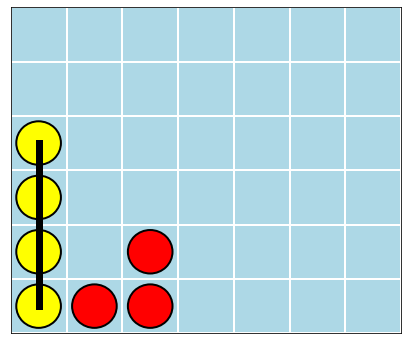

1


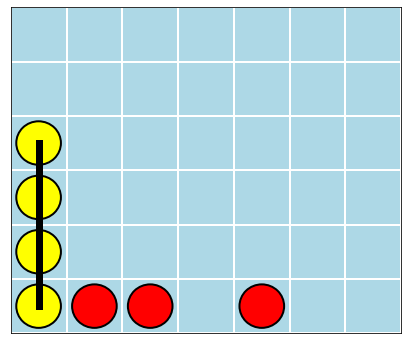

1


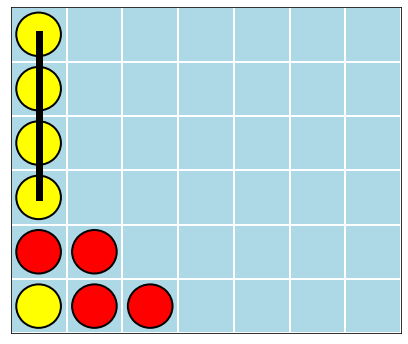

1


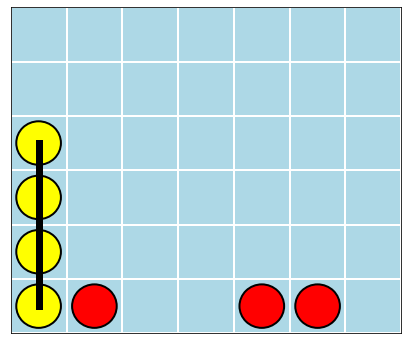

1


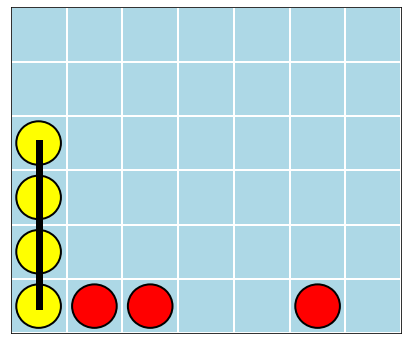

1


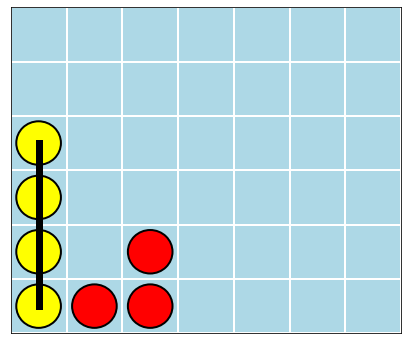

1


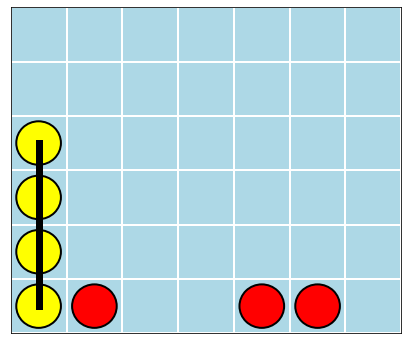

1


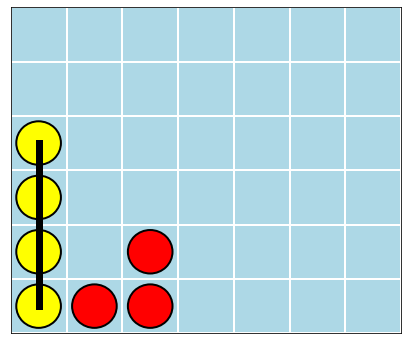

1


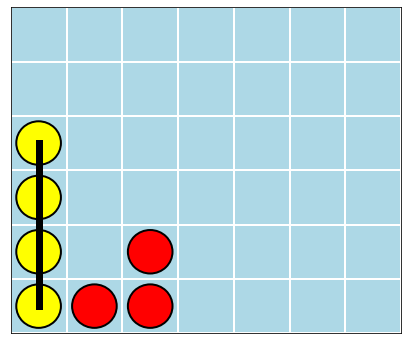

1


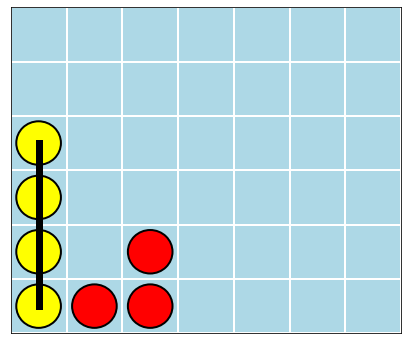

In [10]:
# This cell is supposed to evaluate the Decision Transformer against a MinimaxAgent (or RandomAgent) for a fixed amount of Episodes
model = model.to("cpu")
env = Env()
max_ep_len = max_episode_length
print(f"Maximum Episode Length is {max_ep_len}")
device = "cpu"
TARGET_RETURN = 1

opponent = MinimaxAgent(env, epsilon=0.3)

for ii in range(0,10):

    state_dim = env.field.num_columns * env.field.num_rows
    act_dim = 1
    # Create the decision transformer model
    episode_return, episode_length = 0, 0
    env.reset()
    state = np.array(env.get_state()).flatten()
    target_return = torch.tensor(TARGET_RETURN, device=device, dtype=torch.float32).reshape(1, 1)
    states = torch.from_numpy(state).reshape(1, state_dim).to(device=device, dtype=torch.float32)
    actions = torch.zeros((0, act_dim), device=device, dtype=torch.float32)
    rewards = torch.zeros(0, device=device, dtype=torch.float32)

    timesteps = torch.tensor(0, device=device, dtype=torch.long).reshape(1, 1)
    for t in range(max_ep_len):
        actions = torch.cat([actions, torch.zeros((1, act_dim), device=device)], dim=0)
        rewards = torch.cat([rewards, torch.zeros(1, device=device)])

        action = get_action(
            model,
            states,
            actions,
            rewards,
            target_return,
            timesteps,
        )
        actions[-1] = action
        action = action.detach().cpu().numpy()

        #state, reward, done, _ = env.step(action)
        valid, reward, finished = env.step(int(action), AGENT)
        state = np.array(env.get_state()).flatten()
        #env.render_pretty()

        if finished != -1:
            break
        opp_action = opponent.act(env.field)
        #print(f"Opponent Action: {opp_action}")
        valid, _, finished = env.step(int(opp_action), OPPONENT)
        state = np.array(env.get_state()).flatten()

        cur_state = torch.from_numpy(state).to(device=device).reshape(1, state_dim)
        states = torch.cat([states, cur_state], dim=0)
        rewards[-1] = reward

        pred_return = target_return[0, -1] - reward
        target_return = torch.cat([target_return, pred_return.reshape(1, 1)], dim=1)
        timesteps = torch.cat([timesteps, torch.ones((1, 1), device=device, dtype=torch.long) * (t + 1)], dim=1)

        episode_return += reward
        episode_length += 1

        if finished != -1:
            break

    print(finished)
    env.render_pretty()